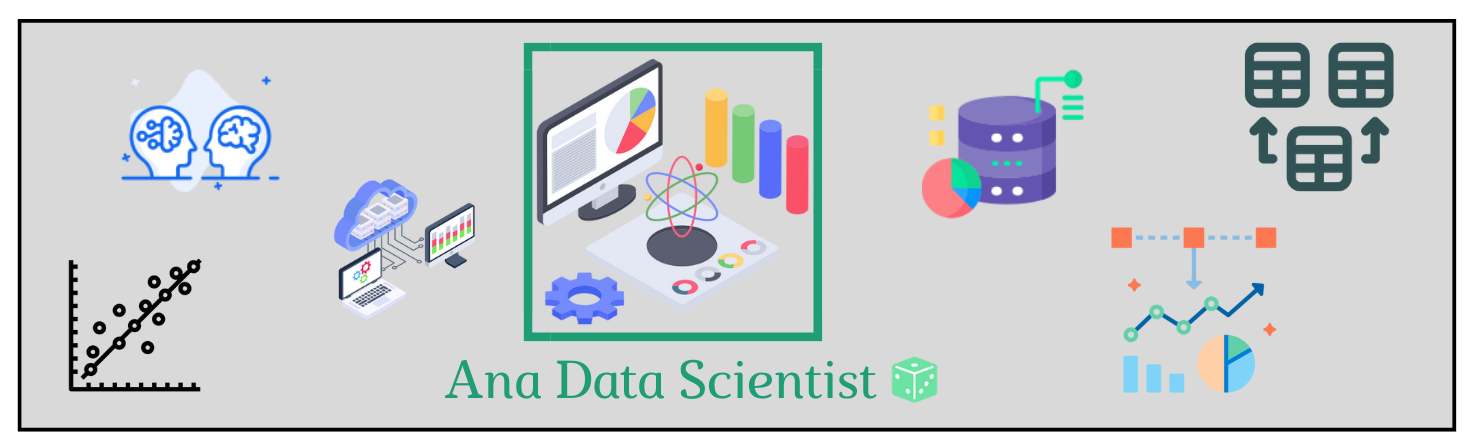

<h1 style="text-align: center; color: #1f9d76"> Projeto Análise de E-commerce Brasileiro (Brazilian E-commerce Analytics)</h1>

<div class="alert alert-block alert-info"><font size="3">
    <b> Project Description:</font><font size="3"></b> Esse projeto tem como objetivo analisar e modelar modelos de Machine Learning com foco em um conjunto de dados público de comércio eletrônico (e-commerce) brasileiro. Os dados utilizados para o desenvolvimento desse projeto é da plataforma Kaggle (plataforma de competição). </font> 
</div>

<font size="5"><a id="sumario"><bold>Summary</bold></a></font>
***

>1. [Importação das Bibliotecas](#ses1)
>2. [Preparando o Ambiente Spark](#ses2)
>3. [Funções](#ses3)
>4. [Carregando os Dados](#ses4)
>5. [Análise Exploratória](#ses5)

<h1 style="text-align:center;" ><a id="ses1">Imports</a></h1>

[VOLTAR](#sumario)

<h3 style="color: #1f9d76">Section Description</h3> 

Importações das bibliotecas utilizadas para o desenvolvimento desse notebook e algumas configurações de saídas de códigos.

In [1]:
# Inicializar o pyspark

import findspark
findspark.init()

In [2]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import missingno as msno
import warnings
import sklearn
import os


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

In [3]:
# Versão da Linguagem Python

from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())
print("")

# Versões de pacotes utilizados 

%reload_ext watermark
%watermark -a "Ana Data Scientist" --iversions

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.8

Author: Ana Data Scientist

pandas    : 1.5.2
seaborn   : 0.12.1
matplotlib: 3.6.2
findspark : 2.0.1
missingno : 0.5.1
sklearn   : 1.2.1
numpy     : 1.22.4



In [4]:
# Para ignorar mensagens de alertas 

warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

# Visualizar todas as colunas do dataset

pd.set_option('display.max_columns', None)

<h1 style="text-align:center;" ><a id="ses2">Preparando o Ambiente Spark</a></h1>

[VOLTAR](#sumario)

In [5]:
# Criar uma conexão com um cluster spark e inicia uma sessão spark

spark_session = SparkSession.builder.appName("Ecommerce-Analytics").getOrCreate()

spark_session

<h1 style="text-align:center;" ><a id="ses3">Funções</a></h1>

[VOLTAR](#sumario)

In [6]:
def convert_date(df: pd.DataFrame):
    """
    Função para converter coluna no tipo date
    
    date_col = lista que vai receber as colunas
    df = dataframe
    return = returna o df com as colunas convertidas
    """
    date_col = []
    
    for column in df.columns:
        if column.startswith('date'):
            date_col.append(column)
            
    for column in date_col:
        df[column] = pd.to_datetime(df[column])
        
    return df

<h1 style="text-align:center;" ><a id="ses4">Carregamento dos dados</a></h1>

[VOLTAR](#sumario)

In [7]:
# Carregando os dados 

path = 'C:/Projetos/Brazilian_Ecommerce_Analysis/02-CodigoFonte/00-DataSets/brazilian_ecommerce_clean/brazilian_ecommerce.csv'

brazilian_ecommerce = pd.read_csv(path)

In [8]:
# Convertendo as colunas de dadtas em tipo date

brazilian_ecommerce = convert_date(brazilian_ecommerce)

In [9]:
# Dos status dos produtos apenas 5 foram cancelados, de acordo com a base, então serão removidos.

brazilian_ecommerce.drop(brazilian_ecommerce.loc[brazilian_ecommerce['order_status'] == 'canceled'].index, inplace=True)

<h1 style="text-align:center;" ><a id="ses5">Análise Exploratória dos Dados</a></h1>

[VOLTAR](#sumario)

<h3 style="color: #1f9d76">Notebook Description</h3>

O objetivo dessa etapa é para analisar e investigar conjuntos de dados, resumir suas principais características e também usar métados visuais para analisar. Essa etapa permite descobrir padrões, detectar anomalias, testar uma hipótese ou verificar suposições. 

<h2 style="color: #1f9d76">Quais produtos apresentam alta demanda?</h2>

In [10]:
# Calculando a quantidade de venda de cada categoria de produto

demanda_product = brazilian_ecommerce[['order_id', 'product_category_name']].\
    groupby('product_category_name', as_index = False).count().\
    rename(columns={'order_id': 'qtd_vendas'}).\
    sort_values('qtd_vendas', ascending=False)

demanda_product['percentual'] = (demanda_product.qtd_vendas / demanda_product.qtd_vendas.sum())* 100

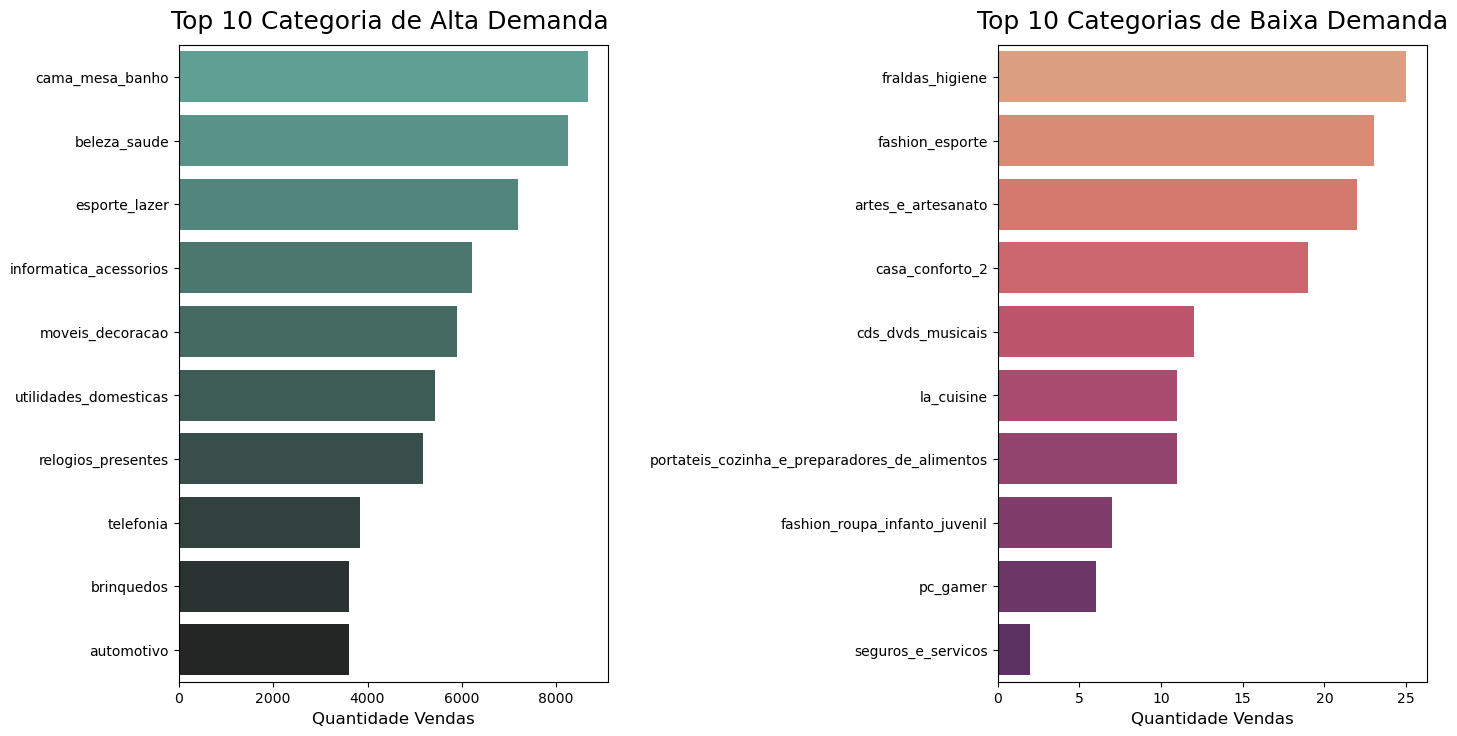

In [11]:
plt.figure(figsize = (15, 8))

# Plot 1: Top 10 categorias mais vendidas
plt.subplot(1,2,1)

top_dez = demanda_product.head(10)

sns.barplot(data = top_dez, x = 'qtd_vendas', y = 'product_category_name', palette = 'dark:#5A9_r')
plt.ylabel(None)
plt.xlabel('Quantidade Vendas', fontdict = {'fontsize': 12})
plt.title('Top 10 Categoria de Alta Demanda ', fontdict = {'fontsize': 18}, pad = 12)

#################################

#Plot 2: Top 10 categorias menos vendidas
plt.subplot(1,2,2)

top_dez_baixo = demanda_product.tail(10)

sns.barplot(data = top_dez_baixo, x = 'qtd_vendas', y = 'product_category_name', palette = 'flare')
plt.ylabel(None)
plt.xlabel('Quantidade Vendas', fontdict = {'fontsize': 12})
plt.title('Top 10 Categorias de Baixa Demanda', fontdict={'fontsize': 18}, pad = 12)

plt.tight_layout(pad = 3)

<h3 style="color: #cca002">Obervações:</h3> 

* O público alvo desse e-commerce, nesse caso, são as pessoas que compram produtos das categorias de cama mesa e banho, beleza e saúde, esporte e lazer, entre outras categorias representadas no primeiro gráfico acima (Top 10 Categoria de Alta Demanda).


* E as categorias de produtos que estão ficando absoletos ou com baixa demandas são das categorias de seguros e serviços, pc games, fashion roupa infato juvenil e os demais apresentado no segu

<h2 style="color: #1f9d76">Em quais estados se concentram as maiores e menores taxas de vendas?</h2>

In [12]:
# Calculando quantidade de vendas por estados

demanda_estado = brazilian_ecommerce[['order_id', 'customer_geolocation_state']].\
    groupby('customer_geolocation_state', as_index=False).count().\
    rename(columns={'order_id': 'qtd_vendas'}).\
    sort_values('qtd_vendas', ascending=False)                                                                  

demanda_estado['percentual'] = (demanda_estado.qtd_vendas / demanda_estado.qtd_vendas.sum())* 100

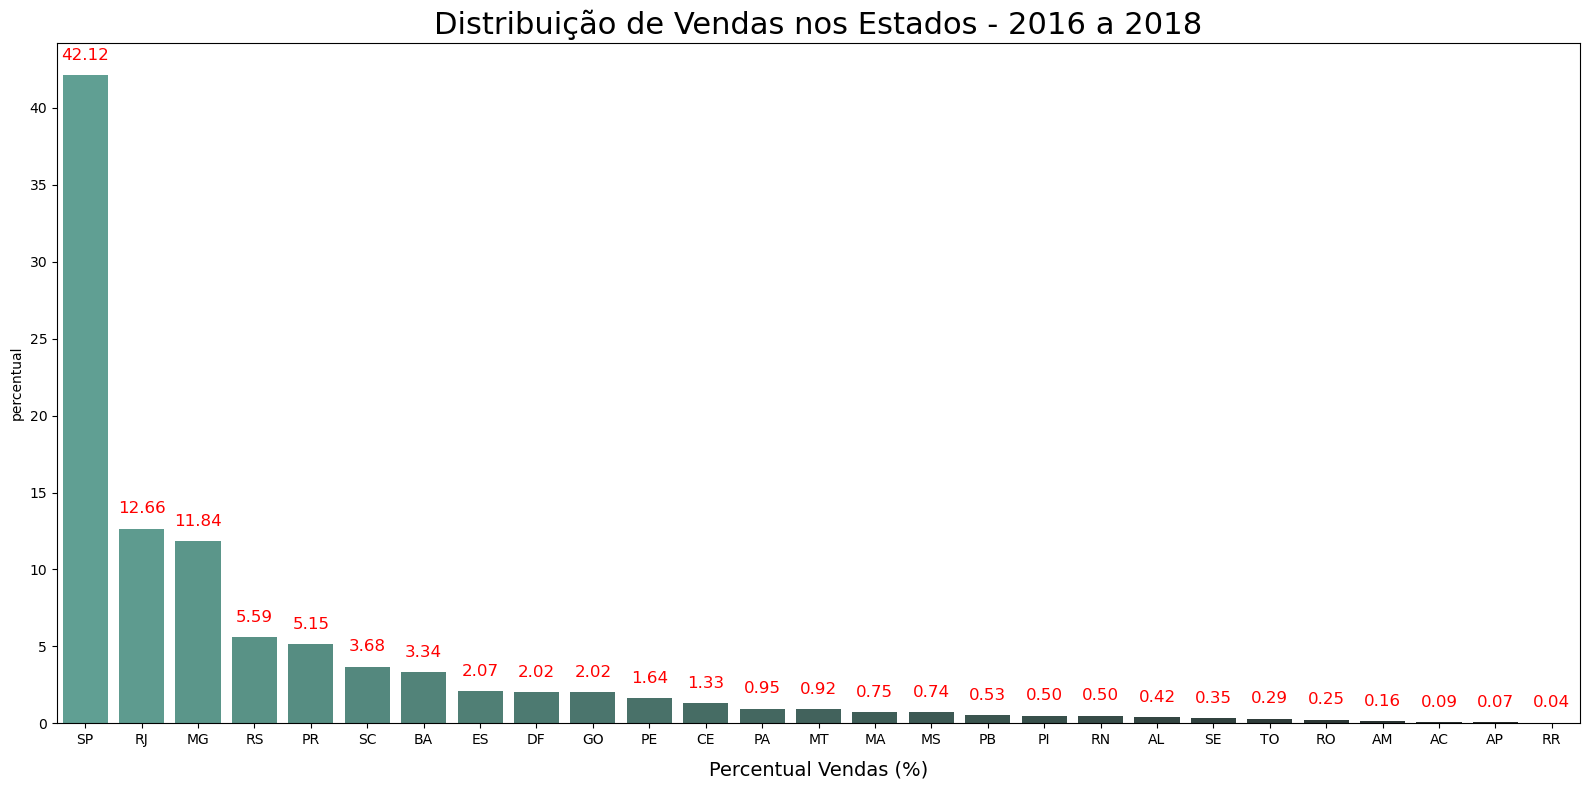

In [13]:
plt.figure(figsize=(16,8))

ax = sns.barplot(y = 'percentual', x = 'customer_geolocation_state', data = demanda_estado, palette = 'dark:#5A9_r')

# for i, v in enumerate(demanda_estado['percentual']):
#     ax.text(v, i+.20,'  {:.2f}'.format(v)+'%', color='black')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
           height + 1,
           '{:.2f}'.format((height)),
            ha = 'center', color='red', fontsize = 12)
    
    
plt.title('Distribuição de Vendas nos Estados - 2016 a 2018', fontsize=22)
plt.xlabel('Percentual Vendas (%)', fontsize=14, labelpad = 10)
plt.tight_layout()

<h3 style="color: #cca002">Obervações:</h3> 

* Pelo gráfico acima percebemos que a maioria das vendas vem de clientes localizados nos estados de São Paulo (SP), em seguida por Rio de Janeiro (RJ) e Minas Gerais (MG).


* E os estados com as menores vendas são Roraima (RR), Amapá (AP) e Acre (AC).

<h2 style="color: #1f9d76">Como foram as vendas ao longo do tempo?</h2>

In [14]:
# Calculando as vendas mensais

vendas_mensais = brazilian_ecommerce[['order_id', 'date_purchase']]

# Criando a coluna de mês e ano 
lista= []
for item in vendas_mensais.date_purchase:
    year_month = (str(item).split('-')[0]+'-'+str(item).split('-')[1])
    lista.append(year_month)
    
vendas_mensais['year_month'] = pd.to_datetime(lista)

vendas_mensais = vendas_mensais[['order_id', 'year_month']].\
    groupby('year_month', as_index=False).count().\
    rename(columns={'order_id': 'qtd_vendas'}).\
    sort_values('qtd_vendas', ascending=False)  

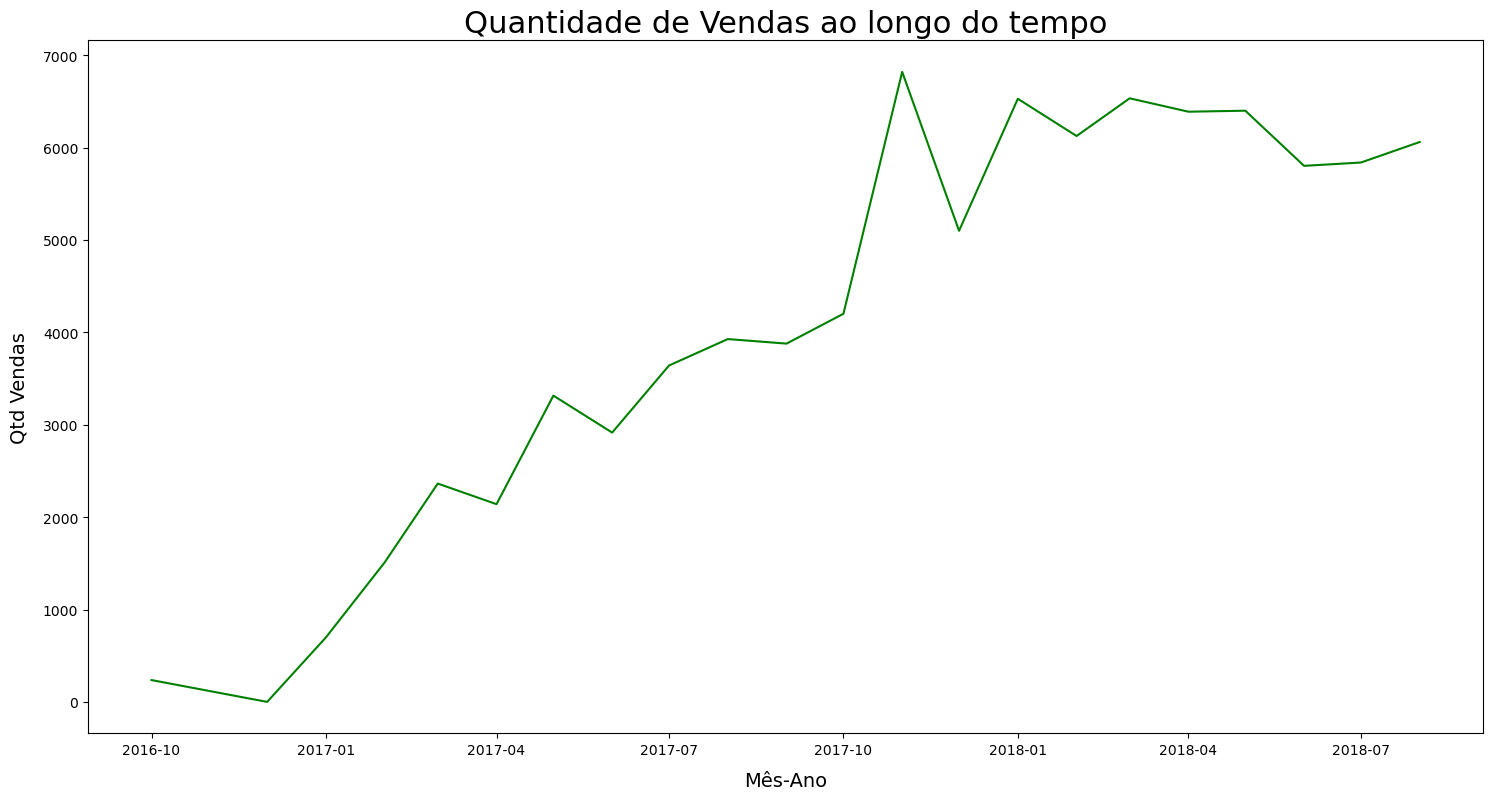

In [15]:
plt.figure(figsize = (18,9))

sns.lineplot(data = vendas_mensais, x = 'year_month', y = 'qtd_vendas', 
             ci=None, color = 'green')

plt.title('Quantidade de Vendas ao longo do tempo', fontsize=22)
plt.xlabel('Mês-Ano', fontsize=14, labelpad = 10)
plt.ylabel('Qtd Vendas', fontsize=14, labelpad = 10)
plt.show()

<h3 style="color: #cca002">Obervações:</h3> 

Pelo gráfico percebemos que as vendas têm crescido ao longo do tempo, tendo um pico ali mais pro final de 2017, provavlmente devido ao natal.

<h2 style="color: #1f9d76">Há alguma infuência no número de fotos publicada do produto com a quantidade de sua venda?</h2>

In [16]:
# Calculando a quantidade de fotos de cada categoria 

photos_product = brazilian_ecommerce[['product_category_name', 'product_photos_qty']].\
    groupby('product_category_name',as_index = False).sum().\
    sort_values(by='product_photos_qty',ascending = False)

# Mesclando com a quantidade de vendas de cada categoria

photos_product = pd.merge(photos_product, demanda_product[['product_category_name', 'qtd_vendas']],
                          on = 'product_category_name')

In [17]:
# Correlação entre a quantidade de fotos e o número de vendas

photos_product.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,product_photos_qty,qtd_vendas
product_photos_qty,1.00,0.97
qtd_vendas,0.97,1.00


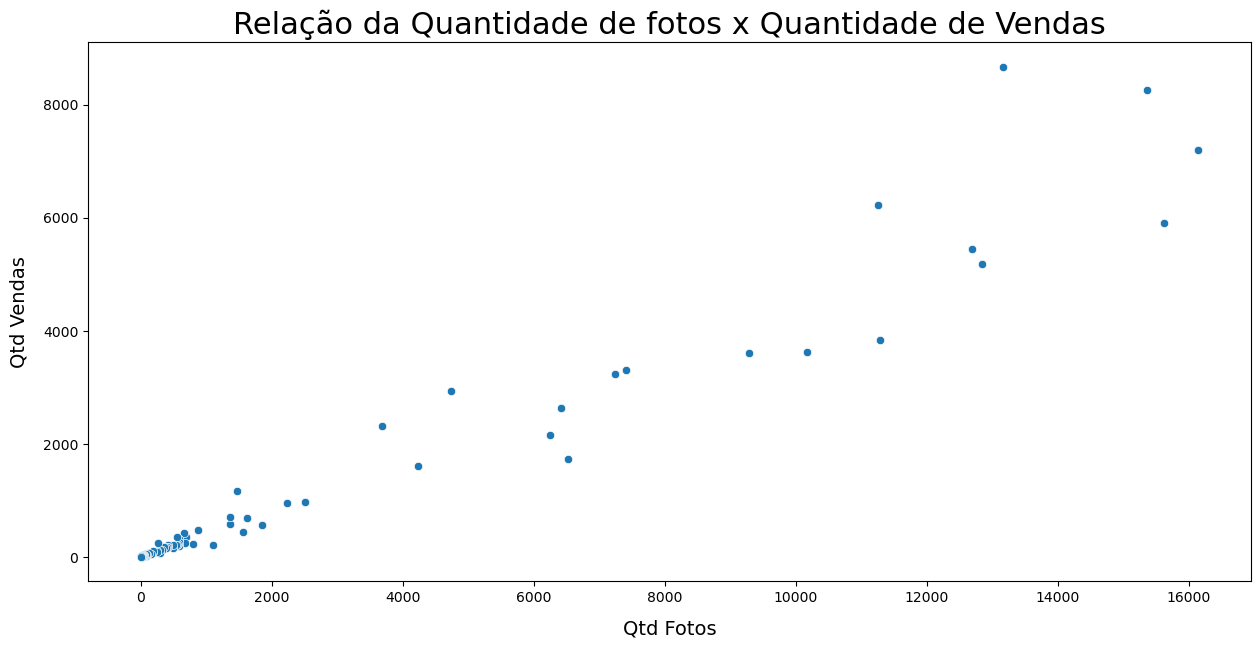

In [18]:
plt.figure(figsize = (15,7))
sns.scatterplot(data = photos_product, x = 'product_photos_qty', y = 'qtd_vendas')

plt.title('Relação da Quantidade de fotos x Quantidade de Vendas', fontsize=22)
plt.xlabel('Qtd Fotos', fontsize=14, labelpad = 10)
plt.ylabel('Qtd Vendas', fontsize=14, labelpad = 10)
plt.show()
plt.show()

<h3 style="color: #cca002">Obervações:</h3> 

Pelas análises visuais (matrix de correlação e o gráfico de scatterplot) mostram que há sim uma correlação positiva entre a quantidade de fotos e a venda do produto, quando mais foto tem o produto na sua publicação a maior é a chance de uma clinte efetuar a sua compra. 

<h2 style="color: #1f9d76">Avaliações dos clientes</h2>

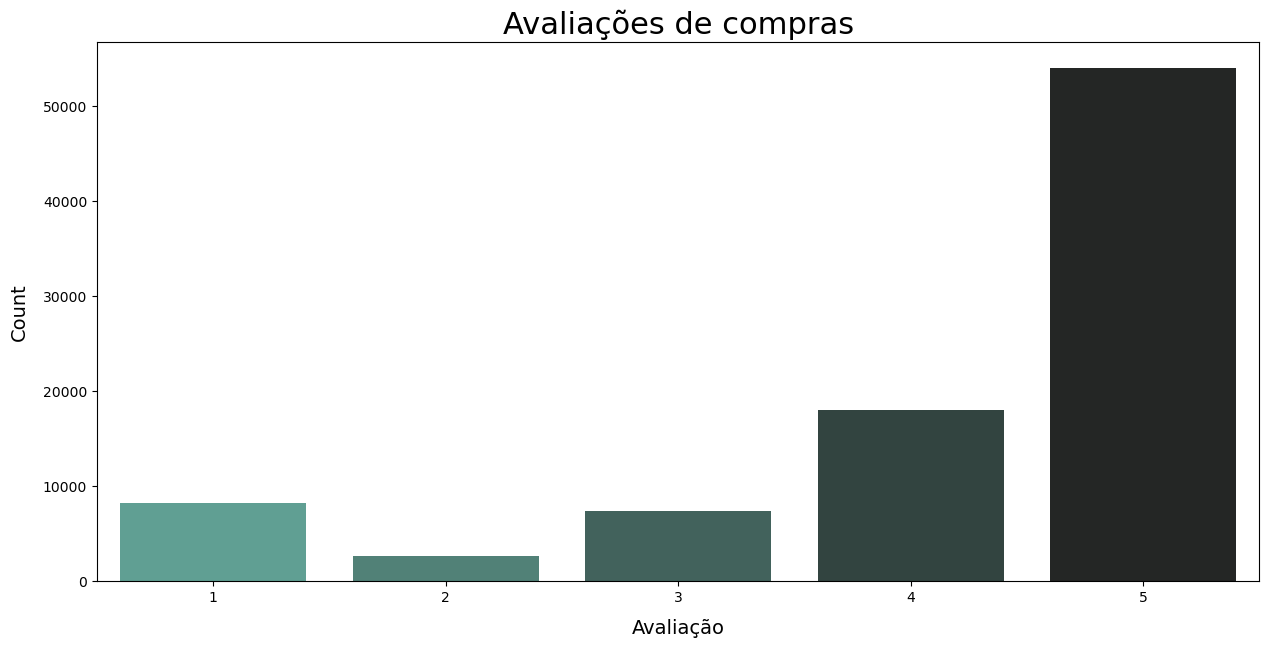

In [19]:
plt.figure(figsize = (15,7))

sns.countplot(x = brazilian_ecommerce.review_score, palette = 'dark:#5A9_r')

plt.title('Avaliações de compras', fontsize=22)
plt.xlabel('Avaliação', fontsize=14, labelpad = 10)
plt.ylabel('Count', fontsize=14, labelpad = 10)
plt.show()

<h3 style="color: #1f9d76">Categorias de Produtos mais avaliados positivamente</h3>

In [20]:
aval_product = pd.DataFrame(brazilian_ecommerce[['product_category_name','review_score']].\
                            value_counts()).reset_index().rename(columns={0: 'qtd_avaliacao'})

In [21]:
# 15 produtos com as menhlores avaliações de clientes

aval_product.loc[(aval_product.review_score == 5) &
               (aval_product.qtd_avaliacao >= aval_product.qtd_avaliacao.mean()), 'product_category_name'].head(15).to_list()

['beleza_saude',
 'cama_mesa_banho',
 'esporte_lazer',
 'informatica_acessorios',
 'moveis_decoracao',
 'utilidades_domesticas',
 'relogios_presentes',
 'brinquedos',
 'automotivo',
 'telefonia',
 'cool_stuff',
 'ferramentas_jardim',
 'perfumaria',
 'bebes',
 'papelaria']

<h2 style="color: #1f9d76">Forma de Pagamento mais Utilizadas</h2>

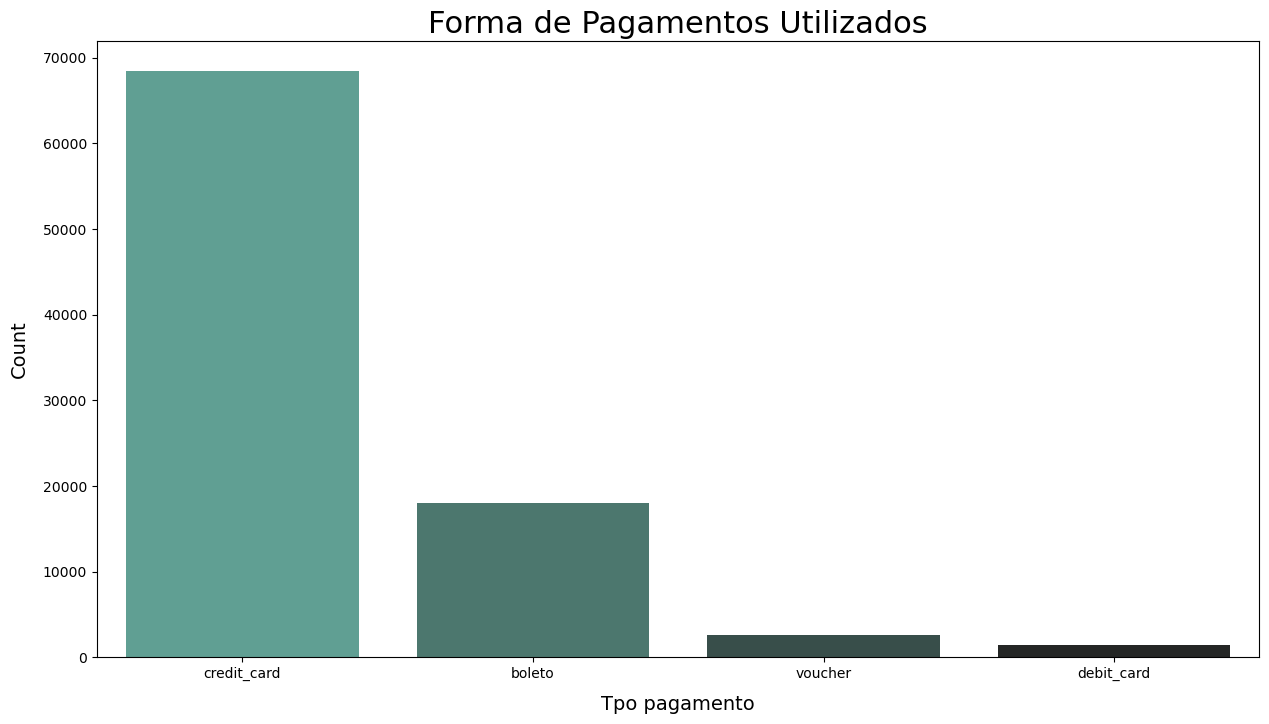

In [22]:
plt.figure(figsize = (15,8))

sns.countplot(x = brazilian_ecommerce.payment_type, palette = 'dark:#5A9_r')

plt.title('Forma de Pagamentos Utilizados', fontsize=22)
plt.xlabel('Tpo pagamento', fontsize=14, labelpad = 10)
plt.ylabel('Count', fontsize=14, labelpad = 10)
plt.show()

<h3 style="color: #cca002">Obervações:</h3> 

A forma de pagamento mais utilizadas pelos clientes é o cartão de crédito seguido pelo boleto.

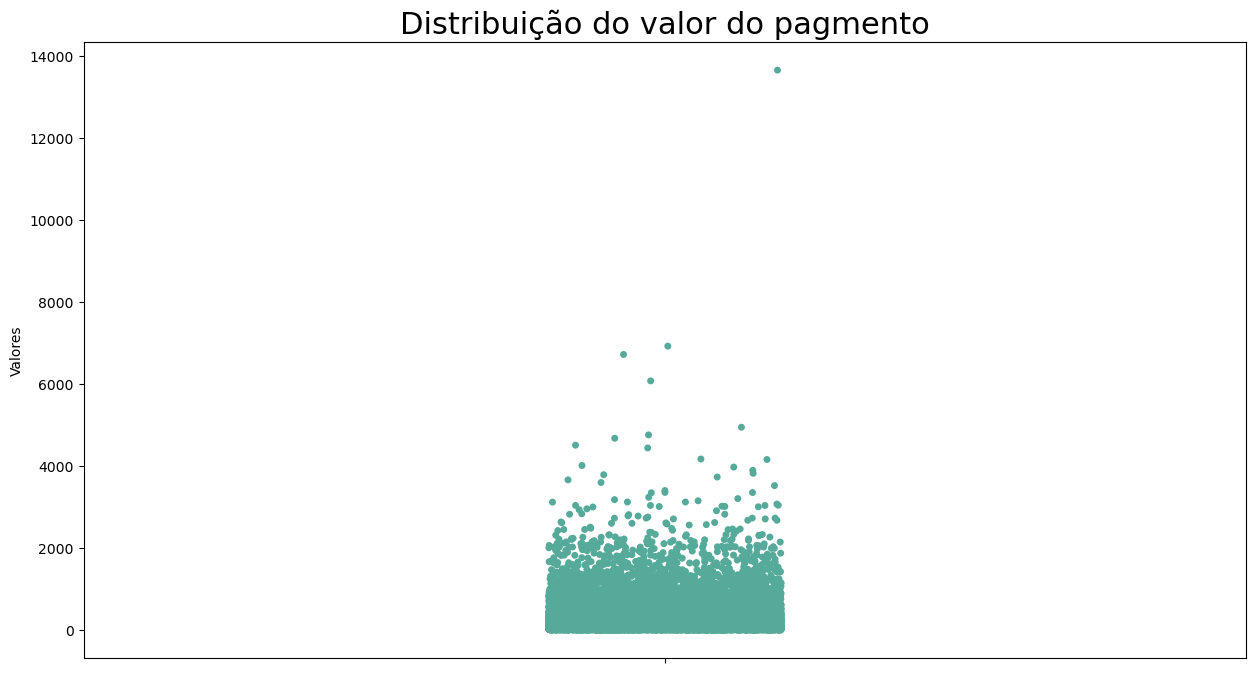

In [23]:
# Distibuição do valor do pagamento mensal

plt.figure(figsize = (15,8))

sns.stripplot(y = brazilian_ecommerce.payment_value, palette = 'dark:#5A9_r').set(xlabel = None, ylabel = None)

plt.title('Distribuição do valor do pagmento', fontsize=22)
plt.ylabel('Valores')
plt.show()

<h3 style="color: #cca002">Obervações:</h3> 
    
A maioria dos valores dos produtos se concentram abaixo 2000 mil reais e tendo algo valores foram do padrão. 

<h2 style="color: #1f9d76">Conclusão</h2>

[VOLTAR](#sumario)

Neste notebook, exploramos uma abordagem de análise exploratória a fim de entender melhor o comportamento dos dados e responder algumas perguntas levantadas. 